
This colab provides a walk-through examples for calculating fractal parameters, as described in the following paper:

```
Alabdulmohsin, Ibrahim, Vinh Q. Tran, and Mostafa Dehghani.
"Fractal Patterns May Unravel the Intelligence in Next-Token Prediction."
arXiv preprint arXiv:2402.01825 (2024).
```


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/google-research/blob/master/fractals_language/fractal_patterns_in_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
!nvidia-smi -L  # code was tested with T4
!free -g

GPU 0: NVIDIA RTX A6000 (UUID: GPU-4afe1d35-434c-ab9d-bfeb-c3f7c58047d8)
               total        used        free      shared  buff/cache   available
Mem:              61          15           3           0          42          45
Swap:             63           6          57


In [3]:
!pip install -q datasets transformers

In [2]:
import datasets
import torch
import tqdm.notebook
import transformers

import numpy as np
import sklearn.linear_model
import jax, jax.numpy as jnp

import matplotlib
import matplotlib.pyplot as plt

np.random.seed(2024)

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Utils

In [41]:
# These default values are different in the paper. For illustration purposes
# here, we use only 100 documents. In the paper, we use 1K documents per domain.
# See the docstrings for how to select arguments carefully.

DEFAULT_SCALES = [25, 50, 75, 100, 200]
DEFAULT_SAMPLES_PER_DOC = 100
DEFAULT_EPS = 5e-2


latex_context = {
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'font.family': 'sans-serif',
    'font.size': 20.0,
    'legend.fontsize': 20.0,
    'axes.labelsize': 20.0,
    'axes.titlesize': 20.0,
    'xtick.labelsize': 20.0,
    'ytick.labelsize': 20.0,
    'axes.axisbelow': True,
}


def power_law_fit(x, y):
  """Fit a power law to the data (x, y)."""
  ones_logx = np.stack([np.ones_like(x), np.log(x)], axis=1)
  logy = np.log(y)
  clf = sklearn.linear_model.LinearRegression(
      fit_intercept=False).fit(ones_logx, logy)
  return clf.coef_[0], clf.coef_[1]  # coeff, exponent


def plot_power_law(x, y,
                   xlabel, ylabel, title='', yscale='',
                   ylim=None, xlim=None, xticks=None, yticks=None):
  """Plot a power law fit to the data (x, y)."""
  if xlim is None:
    minx, maxx = min(x), max(x)
  else:
    minx, maxx = tuple(xlim)

  log_beta, c = power_law_fit(x, y)
  xp = np.linspace(minx, maxx, 100)
  yp = np.exp(log_beta) * np.power(xp, c)

  with matplotlib.rc_context({**latex_context}):
    fig, axes = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)

    axes.scatter(x, y, s=200, marker="o")
    axes.plot(xp, yp, 'red')
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale('log')
    axes.grid(axis='y')
    axes.set_ylim(ylim)
    axes.set_xlim(xlim)
    if yscale == 'log': axes.set_yscale('log')
    if title: axes.set_title(title)
    if xticks: axes.set_xticks(xticks)
    if yticks: axes.set_yticks(yticks)
  return fig

# Language model
We use GPT2 as an example in this colab demo.

In [42]:
# model_name = 'gpt2'
model_name = "Qwen/Qwen1.5-1.8B"
model = transformers.AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [43]:
MAX_LENGTH = 1024  # gpt2 max supported sequence length

# Dataset

In [8]:
ds = datasets.load_dataset('scientific_papers', 'arxiv', split='validation')
ds.info

/home/kerjan/miniconda3/envs/googlehurst/lib/python3.11/site-packages/datasets/load.py:1461: FutureWarning: The repository for scientific_papers contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scientific_papers
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetInfo(description='\nScientific papers datasets contains two sets of long and structured documents.\nThe datasets are obtained from ArXiv and PubMed OpenAccess repositories.\n\nBoth "arxiv" and "pubmed" have two features:\n  - article: the body of the document, pagragraphs seperated by "/n".\n  - abstract: the abstract of the document, pagragraphs seperated by "/n".\n  - section_names: titles of sections, seperated by "/n".\n\n', citation='\n@article{Cohan_2018,\n   title={A Discourse-Aware Attention Model for Abstractive Summarization of\n            Long Documents},\n   url={http://dx.doi.org/10.18653/v1/n18-2097},\n   DOI={10.18653/v1/n18-2097},\n   journal={Proceedings of the 2018 Conference of the North American Chapter of\n          the Association for Computational Linguistics: Human Language\n          Technologies, Volume 2 (Short Papers)},\n   publisher={Association for Computational Linguistics},\n   author={Cohan, Arman and Dernoncourt, Franck and Kim, Doo Soon and Bu

When calculating fractal parameters, we calculate them over a collection of documents, to ensure we have enough independent samples when estimating, for example, autocorrelations. In the paper, we used 1K documents per domain. For illustration purposes here, we only use 100.

In [9]:
num_documents = 100  #@param = 'int'
it = iter(ds)

texts = []
for _ in tqdm.notebook.tqdm(range(num_documents)):
  b = next(it)
  texts.append(b['article'])  # + '\n'
len(texts)

  0%|          | 0/100 [00:00<?, ?it/s]

100

In [10]:
texts[0]  # example

"the interest in anchoring phenomena and phenomena in confined nematic liquid crystals has largely been driven by their potential use in liquid crystal display devices .\nthe twisted nematic liquid crystal cell serves as an example .\nit consists of a nematic liquid crystal confined between two parallel walls , both providing homogeneous planar anchoring but with mutually perpendicular easy directions . in this case\nthe orientation of the nematic director is tuned by the application of an external electric or magnetic field .\na precise control of the surface alignment extending over large areas is decisive for the functioning of such devices .\nmost studies have focused on nematic liquid crystals in contact with laterally uniform substrates . on the other hand substrate inhomogeneities\narise rather naturally as a result of surface treatments such as rubbing .\nthus the nematic texture near the surface is in fact non - uniform .\nthis non - uniformity , however , is smeared out beyon

In [11]:
text = texts[0]
tokens = tokenizer.encode(text, return_tensors='pt')

tokens

tensor([[1782, 2734,  304,  ...,  873,  873,  659]])

# Tokenize

In [12]:
tokens = [tokenizer.encode(texts[i], return_tensors='pt') for i in tqdm.notebook.tqdm(range(len(texts)))]

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
tokens[0]

tensor([[1782, 2734,  304,  ...,  873,  873,  659]])

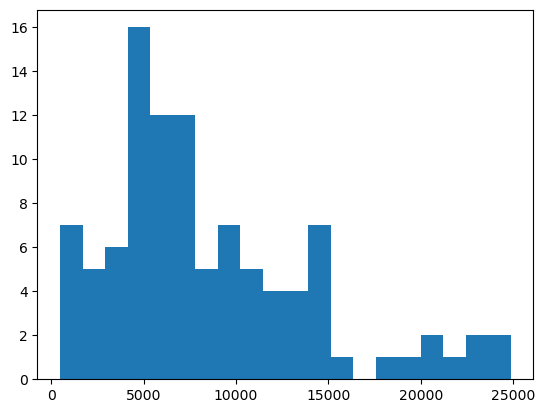

In [14]:
# distribution of document lengths
_ = plt.hist([tokens[i].shape[1] for i in range(len(tokens))], 20)

We only use sufficiently long documents (e.g. > 2K tokens). Later, we drop the leading 128 tokens (warmup) and use only the first 1K tokens (because the second half can contain links, references, etc, not related to the article itself).

In [15]:
filtered_tokens = [tokens[i][0, 0: MAX_LENGTH] \
                   for i in range(len(tokens)) \
                   if tokens[i].shape[1] > 2048]

print(len(filtered_tokens), filtered_tokens[0].shape)

92 torch.Size([1024])


In [16]:
tokenizer.decode(filtered_tokens[0])  # to recover the original text

'the interest in anchoring phenomena and phenomena in confined nematic liquid crystals has largely been driven by their potential use in liquid crystal display devices .\nthe twisted nematic liquid crystal cell serves as an example .\nit consists of a nematic liquid crystal confined between two parallel walls , both providing homogeneous planar anchoring but with mutually perpendicular easy directions . in this case\nthe orientation of the nematic director is tuned by the application of an external electric or magnetic field .\na precise control of the surface alignment extending over large areas is decisive for the functioning of such devices .\nmost studies have focused on nematic liquid crystals in contact with laterally uniform substrates . on the other hand substrate inhomogeneities\narise rather naturally as a result of surface treatments such as rubbing .\nthus the nematic texture near the surface is in fact non - uniform .\nthis non - uniformity , however , is smeared out beyon

# Score
Next, we score all the tokens and convert scores to bits, i.e. we calculate: $-\log p(tokens[i]\;|\; tokens[0:i])$.

In [17]:
print(filtered_tokens[0])
ts = filtered_tokens[0].numpy()
print(ts.shape)
print(torch.tensor(ts))
nts = torch.tensor(ts)[None]
print(nts.shape)

with torch.no_grad():
  print(model(nts.to(device)).logits[0])
  logits = model(nts.to(device)).logits[0].cpu().numpy()

logits.shape    
p = jax.nn.log_softmax(logits)
indices = jnp.array(list(zip(range(len(ts)), ts))).T

print(indices)
print(indices.shape)
bits = -p[tuple(indices)]

bits



tensor([1782, 2734,  304,  ...,  308, 3417,   59])
(1024,)
tensor([1782, 2734,  304,  ...,  308, 3417,   59])
torch.Size([1, 1024])
tensor([[ 1.7373,  2.4381,  0.6194,  ..., -9.0785, -9.0787, -9.0778],
        [ 3.2888,  3.8882,  1.6490,  ..., -8.2229, -8.2238, -8.2228],
        [ 1.5988,  4.3623,  0.9086,  ..., -6.5040, -6.5048, -6.5021],
        ...,
        [ 6.1830,  5.4042,  3.8259,  ..., -5.5988, -5.5985, -5.5982],
        [ 9.4293,  6.6373,  7.1413,  ..., -5.5902, -5.5937, -5.5914],
        [14.5527,  1.7468,  6.5586,  ..., -5.7232, -5.7257, -5.7250]],
       device='cuda:0')


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[[   0    1    2 ... 1021 1022 1023]
 [1782 2734  304 ...  308 3417   59]]
(2, 1024)


Array([12.094329,  8.544958,  8.256259, ..., 12.684136, 16.070343,
       14.743095], dtype=float32)

In [44]:
all_bits = []
all_bits_weird = []
for i in tqdm.notebook.tqdm(range(len(filtered_tokens))):
  ts = filtered_tokens[i].numpy()
  with torch.no_grad():
    logits = model(torch.tensor(ts)[None].to(device)).logits[0].cpu().numpy()
    # convert logits to probability scores over the vocabulary
    p = jax.nn.log_softmax(logits)
    # convert to bits per token
    indices = jnp.array(list(zip(range(len(ts)), ts))).T
    bits = -p[tuple(indices)]

    all_bits.append(bits.tolist()[128:]) # we drop the first 128 tokens (warmpu)

    indices_2 = jnp.array(list(zip(range(len(ts)), ts))).T
    bits_2 = -p[tuple(indices_2)]
        
    # Adjust the slicing to drop the first 128 predictions, considering the offset
    all_bits_weird.append(bits_2.tolist()[127:])  # Adjusted index due to offset

  0%|          | 0/92 [00:00<?, ?it/s]

In [45]:
all_bits = np.array(all_bits)
print(all_bits.shape)
print(all_bits)

all_bits_weird = np.array(all_bits_weird)
print(all_bits_weird.shape)
print(all_bits_weird)

(92, 896)
[[19.31402779  7.21070576 10.81747627 ... 12.68413639 16.07034302
  14.7430954 ]
 [ 9.82578945 12.39125347 13.1853447  ... 13.83002853  5.84761572
   3.23452663]
 [ 8.87221336  7.2103734  13.64375496 ... 10.3221283  16.16235352
  18.08413887]
 ...
 [ 7.51368427  5.20880079  5.41385937 ...  7.36273003 10.81827736
   6.11252451]
 [12.73896408  9.02429295  8.91247845 ... 17.6272831  22.82906151
  18.04635239]
 [10.38643169  9.56160545 10.44069386 ...  8.31360722  7.74936724
  13.0014286 ]]
(92, 897)
[[22.02950668 19.31402779  7.21070576 ... 12.68413639 16.07034302
  14.7430954 ]
 [11.46107197  9.82578945 12.39125347 ... 13.83002853  5.84761572
   3.23452663]
 [ 7.077631    8.87221336  7.2103734  ... 10.3221283  16.16235352
  18.08413887]
 ...
 [ 7.49174929  7.51368427  5.20880079 ...  7.36273003 10.81827736
   6.11252451]
 [16.24657059 12.73896408  9.02429295 ... 17.6272831  22.82906151
  18.04635239]
 [10.10404587 10.38643169  9.56160545 ...  8.31360722  7.74936724
  13.0014286

# Fractal Analysis

## Increment/integral processes

First, let's see how well the model performs. The mean number of bits is the average log-loss.

In [46]:
bits_mean = np.mean(all_bits)
bits_std = np.std(all_bits)
bits_mean, bits_std, np.mean(all_bits_weird), np.std(all_bits_weird)

(11.205365846116921, 3.9934724956701704, 11.20493283157002, 3.9935029570356333)

Now, form the increment $x$ and integral $X$ processes. $x$ is basically the sequence of bits after normalization, while $X$ is the integral of $x$.

In [47]:
x = []
X = []

for k in tqdm.notebook.tqdm(range(len(all_bits))):
  mu = np.mean(all_bits[k])
  sigma = np.std(all_bits[k])
  x.append((all_bits[k] - mu) / sigma)
  X.append(np.cumsum(x[-1]))

x = np.array(x)
X = np.array(X)
x.shape, X.shape

  0%|          | 0/92 [00:00<?, ?it/s]

((92, 896), (92, 896))

Plot the integral process to see how self-similar it is.

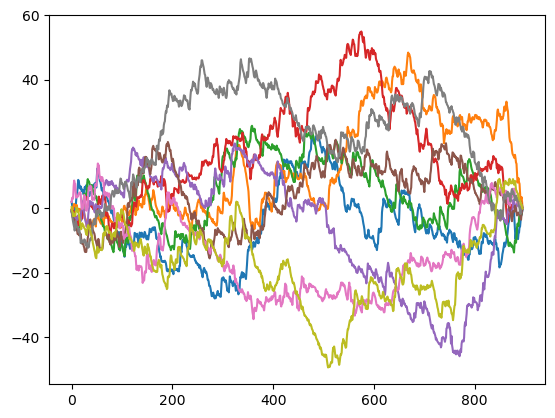

In [48]:
for i in range(0, 9):
    plt.plot(X[i])

## Self-similarity exponent
Note below that we have a large variance in estimating the self-similarity exponent. This is because: (1) we only use 100 documents (we used 1K in the paper) and (2) the scale level goes up to 300 only (in the paper we used >500). So, if you see a large variance, consider increasing the number of documents and increasing the granularity levels.

In [24]:
def get_self_sim_exponent(X,
                          scales=DEFAULT_SCALES,
                          samples_per_doc=DEFAULT_SAMPLES_PER_DOC,
                          eps=DEFAULT_EPS):
  """Calculate the self-similarity exponent.

  Args:
    X: integral process, 1D or 2D array.
    scales: granuality levels. Choose this carefully.
      If it is too large, you will have very few measurements.
      If it is too small, your estimate of the power law relation will be
      unreliable.
    samples_per_doc: number of samples per document. Ideally, this should be
      small and the number of documents should be large.
    eps: used for calculating peak probability scores. Choose this carefully.
      If eps is too small, probability estimates will be unreliable.
      If eps is too large, it doesn't reflect peak probabiliy at the origin.

  Returns:
    S: self-similarity exponent.
    p0: peak probability estimates.
  """
  if X.ndim == 1:
    X = X.reshape((1, -1))
  elif X.ndim > 2:
    raise ValueError('X.ndim must be 1 or 2.')

  p0 = []
  for n in scales:
    all = []
    for i in (range(len(X))):
      for _ in range(samples_per_doc):
        offset = np.random.randint(0, len(X[i]) - n)
        all.append(X[i][offset + n] - X[i][offset])
    all = np.array(all)
    p0.append(np.mean(np.abs(all) < eps))

  # estimate Holder exponent
  return -power_law_fit(scales, p0)[1], p0

In [25]:
# use bootstrapping to estimate uncertainty
np.random.seed(2024)
self_sim_exponent = []
for _ in tqdm.notebook.tqdm(range(10)):
  articles = np.random.choice(np.arange(len(x)), len(x))  # with replacement
  self_sim_exponent.append(get_self_sim_exponent(X[articles])[0])

print(np.mean(self_sim_exponent), np.std(self_sim_exponent))

  0%|          | 0/10 [00:00<?, ?it/s]

0.5287730950918725 0.1082675176590913


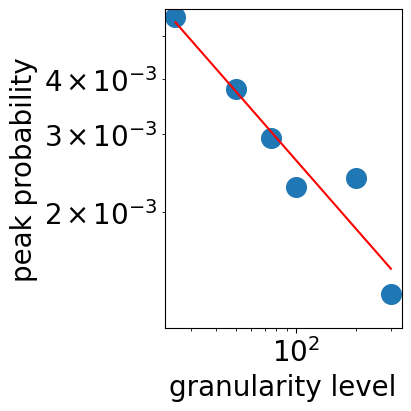

In [ ]:
# see the quality of fit
_, y = get_self_sim_exponent(X)
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     y,
                     yscale='log',
                     xlabel='granularity level',
                     ylabel='peak probability', )

## Hurst exponent

In [49]:
def get_hurst_exponent(x,
                       scales=DEFAULT_SCALES,
                       samples_per_doc=DEFAULT_SAMPLES_PER_DOC):
  """Calculate the Hurst exponent.

  Args:
    x: increment process, 1D or 2D array.
    scales: granuality levels. Choose this carefully.
      If it is too large, you will have very few measurements.
      If it is too small, your estimate of the power law relation will be
      unreliable.
    samples_per_doc: number of samples per document. Ideally, this should be
      small and the number of documents should be large.

  Returns:
    H: Hurst exponent.
    sr: rescaled range estimates.
  """
  if x.ndim == 1:
    x = x.reshape((1, -1))
  elif x.ndim > 2:
    raise ValueError('x.ndim must be 1 or 2.')

  # calculate the rescaled range
  sr = []
  for n in scales:
    som = 0
    count = 0
    for i in range(len(x)):  # to get a reliable etimate, many documents are needed
      for _ in range(samples_per_doc):
        offset = np.random.randint(0, len(x[i]) - n)
        y = x[i, offset: n + offset]
        y = y - np.mean(y)
        Y = np.cumsum(y)
        R = max(Y) - min(Y)
        S = np.std(y)
        som += R / S
        count += 1
    sr.append(som / count)
    
  # estimate Hurst exponent
  return power_law_fit(scales, sr)[1], sr

In [50]:
import math
import sys
import pandas as pd

def __to_inc(x):
    incs = x[1:] - x[:-1]
    return incs

def __get_RS(series, kind):
    """
    Get rescaled range (using the range of cumulative sum
    of deviations instead of the range of a series as in the simplified version
    of R/S) from a time-series of values.

    Parameters
    ----------

    series : array-like
        (Time-)series
    kind : str
        The kind of series (refer to compute_Hc docstring)
    """

    if kind == 'random_walk':
        incs = __to_inc(series)
        mean_inc = (series[-1] - series[0]) / len(incs)
        deviations = incs - mean_inc
        Z = np.cumsum(deviations)
        R = max(Z) - min(Z)
        S = np.std(incs, ddof=1)

    elif kind == 'change':
        incs = series
        mean_inc = np.sum(incs) / len(incs)
        deviations = incs - mean_inc
        Z = np.cumsum(deviations)
        R = max(Z) - min(Z)
        S = np.std(incs, ddof=1)

    if R == 0 or S == 0:
        return 0  # return 0 to skip this interval due undefined R/S

    return R / S

def compute_Hc(series, window_sizes, kind="random_walk", min_window=10, max_window=None, min_sample=100):
    """
    Compute H (Hurst exponent) and C according to Hurst equation:
    E(R/S) = c * T^H

    Refer to:
    https://en.wikipedia.org/wiki/Hurst_exponent
    https://en.wikipedia.org/wiki/Rescaled_range
    https://en.wikipedia.org/wiki/Random_walk

    Parameters
    ----------

    series : array-like
        (Time-)series

    kind : str
        Kind of series
        possible values are 'random_walk', 'change' and 'price':
        - 'random_walk' means that a series is a random walk with random increments;
        - 'price' means that a series is a random walk with random multipliers;
        - 'change' means that a series consists of random increments
            (thus produced random walk is a cumulative sum of increments);

    min_window : int, default 10
        the minimal window size for R/S calculation

    max_window : int, default is the length of series minus 1
        the maximal window size for R/S calculation

    simplified : bool, default True
        whether to use the simplified or the original version of R/S calculation

    Returns tuple of
        H, c and data
        where H and c — parameters or Hurst equation
        and data is a list of 2 lists: time intervals and R/S-values for correspoding time interval
        for further plotting log(data[0]) on X and log(data[1]) on Y
    """

    if len(series)<min_sample:
        raise ValueError(f"Series length must be greater or equal to min_sample={min_sample}" )

    ndarray_likes = [np.ndarray]
    if "pandas.core.series" in sys.modules.keys():
        ndarray_likes.append(pd.core.series.Series)

    # convert series to numpy array if series is not numpy array or pandas Series
    if type(series) not in ndarray_likes:
        series = np.array(series)

    if "pandas.core.series" in sys.modules.keys() and type(series) == pd.core.series.Series:
        if series.isnull().values.any():
            raise ValueError("Series contains NaNs")
        series = series.values  # convert pandas Series to numpy array
    elif np.isnan(np.min(series)):
        raise ValueError("Series contains NaNs")

    RS_func = __get_RS


    err = np.geterr()
    np.seterr(all='raise')

    # max_window = max_window or len(series)-1
    # window_sizes = list(map(
    #     lambda x: int(10**x),
    #     np.arange(math.log10(min_window), math.log10(max_window), 0.19)))
    # window_sizes.append(len(series))

    # print(window_sizes)

    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(series), w):
            if (start+w)>len(series):
                break
            _ = RS_func(series[start:start+w], kind)
            if _ != 0:
                rs.append(_)
        RS.append(np.mean(rs))

    A = np.vstack([np.log10(window_sizes), np.ones(len(RS))]).T
    H, c = np.linalg.lstsq(A, np.log10(RS), rcond=-1)[0]
    np.seterr(**err)

    c = 10**c
    return H, c, [window_sizes, RS]

In [51]:
hurst_exponent = []
hurst_exponent_lib = []
for _ in tqdm.notebook.tqdm(range(1)):
  articles = np.random.choice(np.arange(len(x)), len(x))  # with replacement
  hurst_exponent.append(get_hurst_exponent(x[articles])[0])

print(hurst_exponent)
print(np.mean(hurst_exponent), np.std(hurst_exponent))

  0%|          | 0/1 [00:00<?, ?it/s]

[0.6081432408111815]
0.6081432408111815 0.0


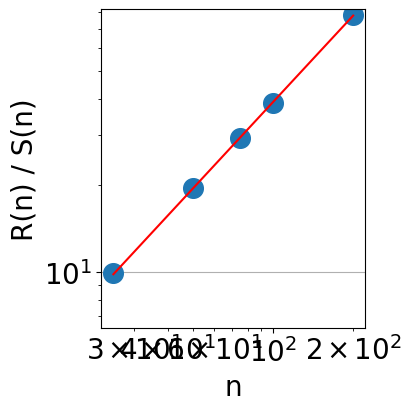

In [54]:
# see the quality of fit
_, y = get_hurst_exponent(X)
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     y,
                     yscale='log',
                     xlabel='n',
                     ylabel='R(n) / S(n)')

## Joseph exponent

In [ ]:
def get_joseph_exponent(x,
                        scales=DEFAULT_SCALES,
                        samples_per_doc=DEFAULT_SAMPLES_PER_DOC):
  """Calculate the Joseph exponent.

  Args:
    x: increment process, 1D or 2D array.
    scales: granuality levels. Choose this carefully.
      If it is too large, you will have very few measurements.
      If it is too small, your estimate of the power law relation will be
      unreliable.
    samples_per_doc: number of samples per document. Ideally, this should be
      small and the number of documents should be large.

  Returns:
    J: Joseph exponent.
    sigmas: standard deviations estimate.
  """
  if x.ndim == 1:
    x = x.reshape((1, -1))
  elif x.ndim > 2:
    raise ValueError('x.ndim must be 1 or 2.')

  sigmas = []
  v = []
  for n in scales:
    for i in range(len(x)):
      for _ in range(samples_per_doc):
        offset = np.random.randint(0, len(x[i]) - n)
        v.extend([X[i][offset + n] - X[i][offset]])
    sigmas.append(np.std(v))

  # estimate Joseph exponent
  return power_law_fit(scales, sigmas)[1], sigmas

In [ ]:
joseph_exponent = []
for _ in tqdm.notebook.tqdm(range(10)):
  articles = np.random.choice(np.arange(len(x)), len(x))  # with replacement
  joseph_exponent.append(get_joseph_exponent(x)[0])

print(np.mean(joseph_exponent), np.std(joseph_exponent))

  0%|          | 0/10 [00:00<?, ?it/s]

0.35772080370919374 0.002647717654797778


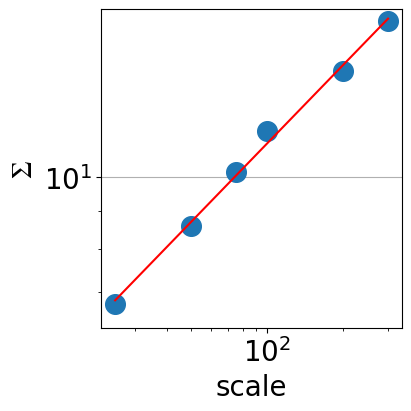

In [ ]:
# see the quality of fit
_, y = get_joseph_exponent(X)
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     y,
                     yscale='log',
                     xlabel='scale',
                     ylabel='$\Sigma$')